### Load Libraries

In [1]:
import pandas as pd
import numpy as np
import os, sys, glob, json, pickle
import seaborn as sn
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import accuracy_score, f1_score, recall_score, cohen_kappa_score
from sklearn.metrics import precision_score, matthews_corrcoef, roc_auc_score
import seaborn as sn
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from matplotlib import pylab
from matplotlib_venn import venn3, venn3_circles

### Prediction of validation and test sets using three best performing models: 
### fingerprints, pharmacophore, and rdkit descriptors

In [2]:
def predict_validation_test(models):
    temp = 'balanced_randomsplit7_70_15_15'
    split = ['_va', '_te']
    for s in split:
        for m in models:
            fp = results[m]
            fingerprint = np.load('valid_test_features/'+\
                                 fp+'-'+m+'-'+temp+s+'.npy')
            rdkDes = np.load('valid_test_features/'+\
                                 'rdkDes'+'-'+m+'-'+temp+s+'.npy')
            pharma = np.load('valid_test_features/'+\
                                 'tpatf'+'-'+m+'-'+temp+s+'.npy')
            volsurf = np.load('valid_test_features/'+\
                             'volsurf'+'-'+m+'-'+temp+s+'.npy')
            fingerprint_model = pickle.load(open('models_tuned_best/'\
                                                +fp+'-'+m+'-'+temp+'.pkl', 'rb'))
            rdkDes_model = pickle.load(open('models_tuned_best/'\
                                                +'rdkDes'+'-'+m+'-'+temp+'.pkl', 'rb'))
            pharma_model = pickle.load(open('models_tuned_best/'\
                                            +'tpatf'+'-'+m+'-'+temp+'.pkl', 'rb'))
            volsurf_model = pickle.load(open('models_tuned_best/'\
                                            +'volsurf'+'-'+m+'-'+temp+'.pkl', 'rb'))

            fp_list = [fingerprint, rdkDes, pharma, volsurf]
            models_list = [fingerprint_model, rdkDes_model, pharma_model, volsurf_model]
            df = pd.read_csv('combined_data/'+m+'/'+m+'-'+temp+\
                                  s+'.csv')
            
            fpnames = ['fingerprint', 'rdkDescriptors', 'pharmacophore', 'volsurf']
            for finger, mod, fpname in zip(fp_list, models_list, fpnames):
                X_true = finger[:,:-1]
                y_true = finger[:,-1]
                y_pred = mod.predict(X_true)
                y_pred_label = y_pred.tolist()
                y_prob = mod.predict_proba(X_true)[:,1]
                df.insert(len(df.columns), fpname+'_pred_label', y_pred_label)
                df.insert(len(df.columns), fpname+'_pred_prob', y_prob)
                
                if not os.path.isdir('valid_test_csv_pred'+'/'+m):
                    os.mkdir('valid_test_csv_pred'+'/'+m)
                df.to_csv('valid_test_csv_pred/'+m+'/'+m+s+'.csv', index=False)                

### Make dictionary of best models and feature types among fingperint rdkit descriptors, and pharmacophore

In [3]:
def best_models_dictn():
    results= {}
    for f in glob.glob('reports_tuned_best/*.json'):
        fp,_ = os.path.splitext(os.path.basename(f))
        modelName = fp[:-42]
        modelName2 = modelName.split('-')[1:]
        modelName3 = "-".join(modelName2)
        fpname = fp.split('-')[0]
        if fpname == 'tpatf' or fpname == 'rdkDes' or fpname == "volsurf":  
            continue
        else:
            results[modelName3]=fpname
    return results
results = best_models_dictn()
models=['3CL', 'ACE2', 'AlphaLISA', 'CoV1-PPE', 'CoV1-PPE_cs', 'CPE' \
        ,'cytotox', 'hCYTOX', 'MERS-PPE','MERS-PPE_cs', 'TruHit']
predict_validation_test(models)

In [4]:
def get_consensus(results):
    for d in os.listdir(results):
        for f in glob.glob(results+'/'+d+'/*.csv'):
            consensus_label, consensus_proba, consensus_volsurf_label,\
            consensus_volsurf_label_proba= [], [], [], []
            df = pd.read_csv(f)
            
            for i in range(len(df)):
                if (df['fingerprint_pred_label'][i]+df['rdkDescriptors_pred_label'][i]+df['pharmacophore_pred_label'][i])>=2.0:
                    consensus_label.append(1.0)
                else:
                    consensus_label.append(0.0) 
                    
                if (df['fingerprint_pred_prob'][i]+df['rdkDescriptors_pred_prob'][i]+df['pharmacophore_pred_prob'][i])/3>0.5:
                    consensus_proba.append(1.0)
                else:
                    consensus_proba.append(0.0)
                    
                if (df['fingerprint_pred_label'][i]+df['volsurf_pred_label'][i]+df['pharmacophore_pred_label'][i])>=2.0:
                    consensus_volsurf_label.append(1.0)
                else:
                    consensus_volsurf_label.append(0.0) 
                    
                if (df['fingerprint_pred_prob'][i]+df['volsurf_pred_prob'][i]+df['pharmacophore_pred_prob'][i])/3>0.5:
                    consensus_volsurf_label_proba.append(1.0)
                else:
                    consensus_volsurf_label_proba.append(0.0)
                    
            df.insert(len(df.columns), 'Consensus_label', consensus_label)
            df.insert(len(df.columns), 'Consensus_prob_label', consensus_proba)
            df.insert(len(df.columns), 'Consensus_volsurf_label', consensus_volsurf_label)
            df.insert(len(df.columns), 'Consensus_volsurf_prob_label', consensus_volsurf_label_proba)            
            
            if f.endswith('_va.csv'):
                df.to_csv('valid_test_csv_pred_cons/valid/'+d+'_va.csv', index=False)
            elif f.endswith('_te.csv'):
                df.to_csv('valid_test_csv_pred_cons/test/'+d+'_te.csv', index=False)

In [5]:
get_consensus('valid_test_csv_pred')

### Evalution metrics

In [6]:
def evaluation_metrics(y_true, y_pred, y_prob):
    Scores = dict()
    roc_auc = roc_auc_score(y_true, y_prob)
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average = 'binary')
    precision = precision_score(y_true, y_pred, average= 'binary')
    recall = recall_score(y_true, y_pred, average = 'binary')
    kappa = cohen_kappa_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    SP = float(tn)/(tn+fp)
    # Convert numpy.float64 to float using 'tolist()' and save the scores in dictonary 
    metrics_list = ['ACC', 'F1_Score', 'Recall', 'Precision', 'Specificity', \
                   'Cohen_Kappa', 'MCC', 'AUC', 'TP', 'TN', 'FP', 'FN']
    scores_list = [acc.tolist(), f1.tolist(), recall.tolist(), precision.tolist(), SP.tolist(), \
                  kappa.tolist(), mcc, roc_auc.tolist(), tp.tolist(), tn.tolist(), fp.tolist(), fn.tolist()]
    for metric, score in zip(metrics_list, scores_list):
        Scores[metric] = score
    return Scores

### Find consensus results

In [7]:
def get_consensus_scores(y_true, y_pred):
    Scores = dict()
    roc_auc = roc_auc_score(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average = 'binary')
    precision = precision_score(y_true, y_pred, average= 'binary')
    recall = recall_score(y_true, y_pred, average = 'binary')
    kappa = cohen_kappa_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    SP = float(tn)/(tn+fp)
    metrics_list = ['ACC', 'F1_Score', 'Recall', 'Precision', 'Specificity', \
                   'Cohen_Kappa', 'MCC', 'AUC', 'TP', 'TN', 'FP', 'FN']
    scores_list = [acc.tolist(), f1.tolist(), recall.tolist(), precision.tolist(), SP.tolist(), \
                  kappa.tolist(), mcc, roc_auc.tolist(), tp.tolist(), tn.tolist(), fp.tolist(), fn.tolist()]
    for metric, score in zip(metrics_list, scores_list):
        Scores[metric] = score
    return Scores

In [8]:
def get_total_scores(models_dir):
    total_dictn = dict()
    for s in os.listdir(models_dir):
        dictn_dir = dict()
        for f in glob.glob(os.path.join(models_dir, s+'/*.csv')):
            df = pd.read_csv(f)
            name= os.path.splitext(os.path.basename(f))[0][:-3]
            dictn_fp = dict()
            for _type in ['fingerprint_pred_label', 'rdkDescriptors_pred_label', 'pharmacophore_pred_label',\
                          'volsurf_pred_label', 'Consensus_label', 'Consensus_prob_label', 'Consensus_volsurf_label', \
                         'Consensus_volsurf_prob_label']:
                y_pred = df[_type].to_list()
                y_true = df['Label'].to_list()
                # y_prob is not used for consensus
                if _type == 'Consensus_label' or _type=='Consensus_prob_label' or \
                _type=='Consensus_volsurf_label' or _type=='Consensus_volsurf_prob_label':
                    scores = get_consensus_scores(y_true, y_pred)
                else:
                    y_prob = df[_type[:-6]+'_prob'].to_list()
                    scores = evaluation_metrics(y_true, y_pred, y_prob)
                dictn_fp[_type] = scores
            dictn_dir[name] = dictn_fp
        total_dictn[s] = dictn_dir
    return total_dictn

In [9]:
results = get_total_scores('valid_test_csv_pred_cons/')
results

{'valid': {'cytotox': {'fingerprint_pred_label': {'ACC': 0.7619047619047619,
    'F1_Score': 0.7590361445783131,
    'Recall': 0.75,
    'Precision': 0.7682926829268293,
    'Specificity': 0.7738095238095238,
    'Cohen_Kappa': 0.5238095238095238,
    'MCC': 0.523958059052495,
    'AUC': 0.8333864795918368,
    'TP': 126,
    'TN': 130,
    'FP': 38,
    'FN': 42},
   'rdkDescriptors_pred_label': {'ACC': 0.7470238095238095,
    'F1_Score': 0.7564469914040115,
    'Recall': 0.7857142857142857,
    'Precision': 0.7292817679558011,
    'Specificity': 0.7083333333333334,
    'Cohen_Kappa': 0.49404761904761907,
    'MCC': 0.49553342702041797,
    'AUC': 0.824936224489796,
    'TP': 132,
    'TN': 119,
    'FP': 49,
    'FN': 36},
   'pharmacophore_pred_label': {'ACC': 0.7708333333333334,
    'F1_Score': 0.7673716012084593,
    'Recall': 0.7559523809523809,
    'Precision': 0.7791411042944786,
    'Specificity': 0.7857142857142857,
    'Cohen_Kappa': 0.5416666666666667,
    'MCC': 0.54190672

 ### Find the best model info:

In [10]:
# Comparision of Volsurf and RDkit Descriptors
total_models = list(results['valid'].keys())
best_f1 = []
best_model = []
model_types = ['rdkDescriptors_pred_label', 'volsurf_pred_label']
for m in total_models:
    f1_m = 0
    model_name = ''
    for mt in model_types:
        f1_score = results['valid'][m][mt]['F1_Score']
        if f1_score > f1_m:
            f1_m = f1_score
            model_name = mt
        else:
            pass
    best_f1.append(f1_m)
    best_model.append(model_name)
print(total_models)
print(best_model)
print(best_f1)

['cytotox', 'CPE', 'ACE2', 'MERS-PPE', 'MERS-PPE_cs', 'CoV1-PPE', 'AlphaLISA', 'TruHit', '3CL', 'CoV1-PPE_cs', 'hCYTOX']
['rdkDescriptors_pred_label', 'volsurf_pred_label', 'rdkDescriptors_pred_label', 'volsurf_pred_label', 'rdkDescriptors_pred_label', 'rdkDescriptors_pred_label', 'rdkDescriptors_pred_label', 'rdkDescriptors_pred_label', 'rdkDescriptors_pred_label', 'rdkDescriptors_pred_label', 'volsurf_pred_label']
[0.7564469914040115, 0.7432432432432431, 0.7755102040816326, 0.8028169014084506, 0.7924528301886792, 0.7315175097276264, 0.8305084745762712, 0.8046874999999999, 0.7764705882352941, 0.8372093023255814, 0.8108108108108109]


In [11]:
# Comparision of Volsurf and RDkit Descriptors
total_models = list(results['valid'].keys())
f1 = []
models = []
for m in total_models:
    RDK_f1 = round(results['valid'][m]['rdkDescriptors_pred_label']['F1_Score'], 3)
    volsurf_f1 = round(results['valid'][m]['volsurf_pred_label']['F1_Score'], 3)
    if RDK_f1 > volsurf_f1:
        f1.append(m+'|'+'RDK->'+str(RDK_f1)+'|'+str(volsurf_f1)+'->VSF')
        models.append(m+'|'+'RDK')
    else:
        f1.append(m+'|'+'VSF->'+str(volsurf_f1)+ '|'+ str(RDK_f1)+'->RDK')
        models.append(m+'|'+'VSF')
# print('Models: \n', total_models)
print('F1 scores: \n', f1)
print('Best RDK or VSF: \n', models)

F1 scores: 
 ['cytotox|RDK->0.756|0.715->VSF', 'CPE|VSF->0.743|0.708->RDK', 'ACE2|RDK->0.776|0.75->VSF', 'MERS-PPE|VSF->0.803|0.795->RDK', 'MERS-PPE_cs|RDK->0.792|0.76->VSF', 'CoV1-PPE|RDK->0.732|0.705->VSF', 'AlphaLISA|RDK->0.831|0.79->VSF', 'TruHit|RDK->0.805|0.802->VSF', '3CL|RDK->0.776|0.759->VSF', 'CoV1-PPE_cs|RDK->0.837|0.723->VSF', 'hCYTOX|VSF->0.811|0.732->RDK']
Best RDK or VSF: 
 ['cytotox|RDK', 'CPE|VSF', 'ACE2|RDK', 'MERS-PPE|VSF', 'MERS-PPE_cs|RDK', 'CoV1-PPE|RDK', 'AlphaLISA|RDK', 'TruHit|RDK', '3CL|RDK', 'CoV1-PPE_cs|RDK', 'hCYTOX|VSF']


In [12]:
# Find Best models 
total_models = list(results['valid'].keys())
best_f1 = []
best_model = []
model_types = list(results['valid']['cytotox'].keys())
for m in total_models:
    f1_m = 0
    model_name = ''
    for mt in model_types:
        f1_score = results['valid'][m][mt]['F1_Score']
        if f1_score > f1_m:
            f1_m = f1_score
            model_name = mt
        else:
            pass
    best_f1.append(round(f1_m, 3))
    best_model.append(m+'|'+model_name)
print(best_model)
print(best_f1)

['cytotox|Consensus_label', 'CPE|Consensus_volsurf_label', 'ACE2|fingerprint_pred_label', 'MERS-PPE|fingerprint_pred_label', 'MERS-PPE_cs|Consensus_label', 'CoV1-PPE|Consensus_prob_label', 'AlphaLISA|Consensus_label', 'TruHit|Consensus_label', '3CL|Consensus_label', 'CoV1-PPE_cs|Consensus_label', 'hCYTOX|volsurf_pred_label']
[0.781, 0.747, 0.816, 0.837, 0.824, 0.773, 0.831, 0.837, 0.809, 0.87, 0.811]


### Plots showing the evaluated metrics 

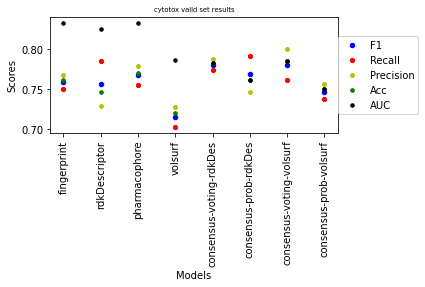

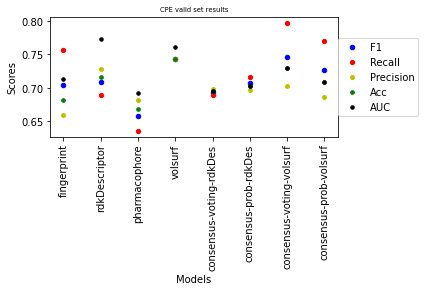

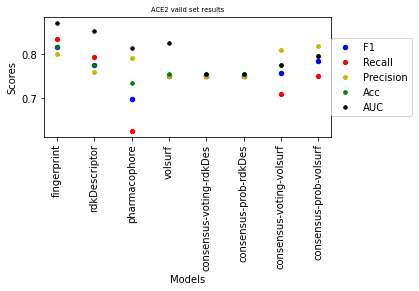

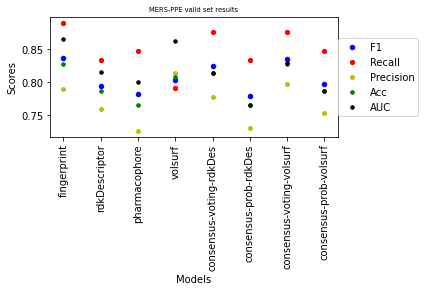

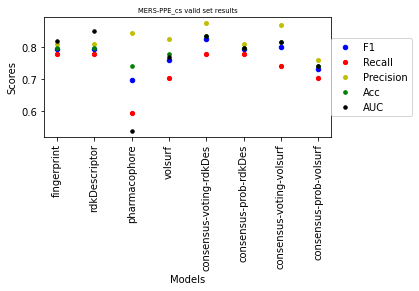

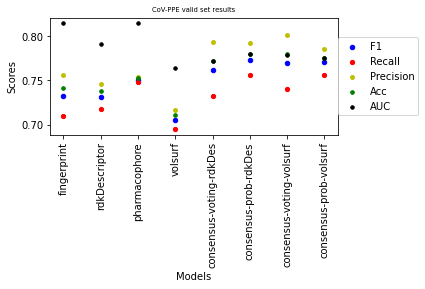

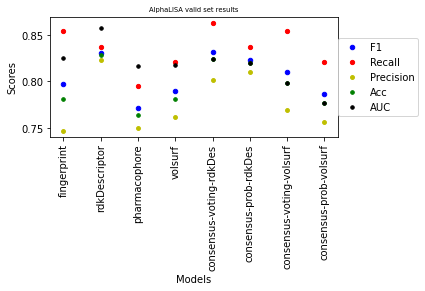

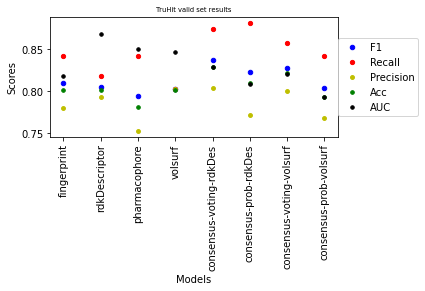

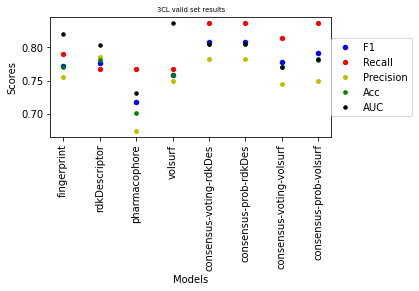

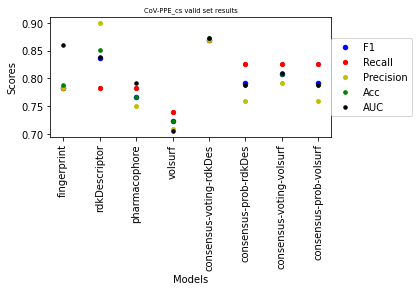

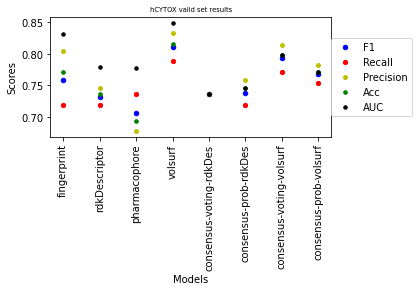

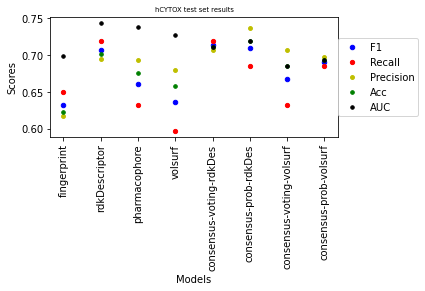

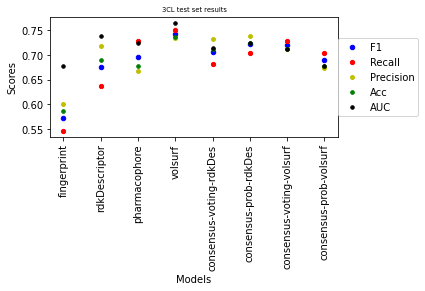

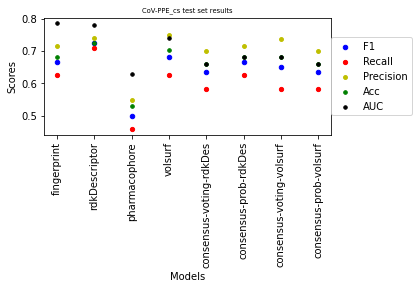

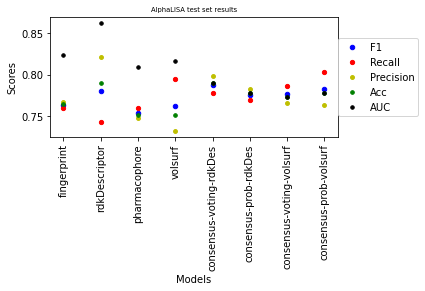

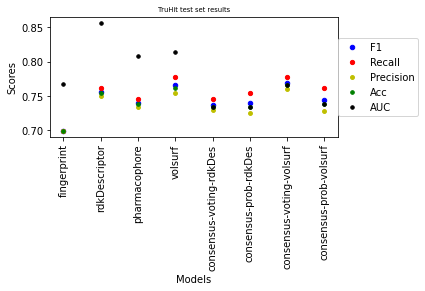

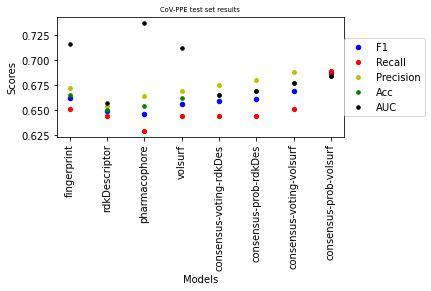

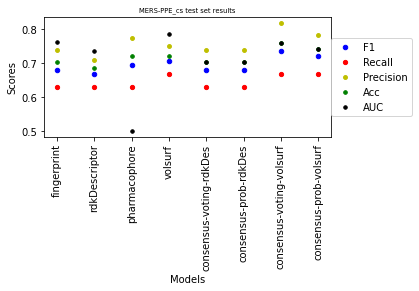

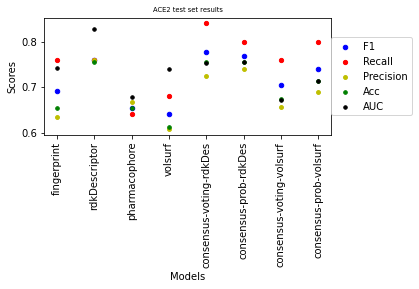

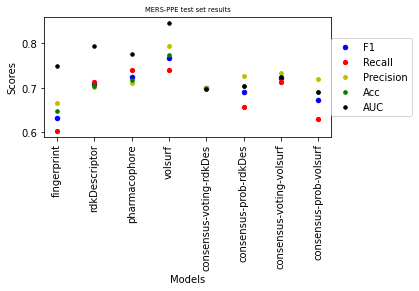

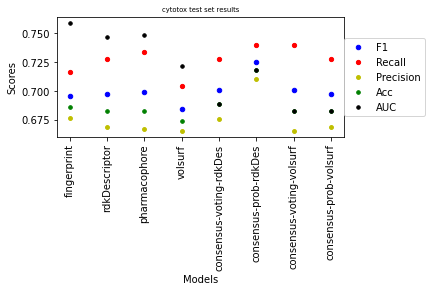

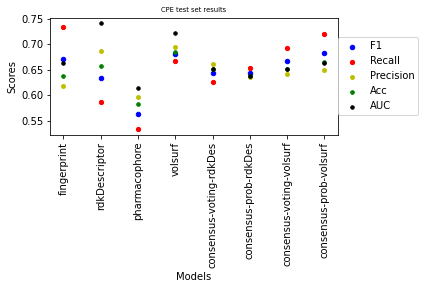

<Figure size 432x288 with 0 Axes>

In [13]:
for s in ['valid', 'test']:
    models = list(results[s].keys())
    for m in models:
        valid_dictn = results[s][m]
        df = pd.DataFrame(valid_dictn)
        df = df.transpose()
        df.insert(0, 'Models', list(valid_dictn.keys()))
        # Select the useful metrics only
        df = df.iloc[:,:-4]
        label = ('fingerprint', 'rdkDescriptor', 'pharmacophore', 'volsurf', 'consensus-voting-rdkDes',\
                 'consensus-prob-rdkDes', 'consensus-voting-volsurf', "consensus-prob-volsurf" )
        # number of xticks--> number of models
        plt.xticks(np.arange(8), label, rotation=90) #, fontsize=6
        plt.scatter(df['Models'].tolist(), df['F1_Score'].tolist(), c='b',s=20, label='F1')
        plt.scatter(df['Models'].tolist(), df['Recall'].tolist(), c='r',s=18, label='Recall')
        plt.scatter(df['Models'].tolist(), df['Precision'].tolist(), c='y',s=15, label='Precision')
        plt.scatter(df['Models'].tolist(), df['ACC'].tolist(), c='g',s=13, label='Acc')
        plt.scatter(df['Models'].tolist(), df['AUC'].tolist(), c='k',s=12, label='AUC')
        plt.xlabel('Models')
        plt.ylabel('Scores')
        plt.legend(loc='center left', bbox_to_anchor=(0.983, 0.5), ncol=1)
        plt.tight_layout()
        if m == 'CoV1-PPE':
            plt.title('CoV-PPE'+' '+s+' set'+ ' results', fontsize=6.7)
        elif m == 'CoV1-PPE_cs':
            plt.title('CoV-PPE_cs'+' '+s+' set'+ ' results', fontsize=6.7)
        else:
            plt.title(m+' '+s+' set'+ ' results', fontsize=6.7)
        plt.savefig('plots/'+m+'-'+s+'.png',dpi=600)
        plt.show()
        plt.clf()

### External Set predictions for CPE and 3CL

In [14]:
def external_pred(ext_files, model):
    files = glob.glob(ext_files)
    for f in files:
        filename = os.path.splitext(os.path.basename(f))[0]
        if model == 'CPE' and filename == 'cpe_external_set_after_phys-chem-filters_stand':
            fingerprint = np.load('external_set_features/'+'lfcfp4-' + filename+'.npy')
            fingerprint_model = \
            pickle.load(open('models_tuned_best/lfcfp4-CPE-balanced_randomsplit7_70_15_15.pkl', 'rb'))
        elif model == '3CL' and filename == '3cl_external_set_stand':
            fingerprint = np.load('external_set_features/'+ 'hashtt-'+ filename+'.npy')
            fingerprint_model = \
            pickle.load(open('models_tuned_best/hashtt-3CL-balanced_randomsplit7_70_15_15.pkl', 'rb'))
        else:
            continue
        rdkDes = np.load('external_set_features/'+ 'rdkDes-'+ filename+'.npy')
        rdkDes_model = \
        pickle.load(open('models_tuned_best/rdkDes-'+ model +'-balanced_randomsplit7_70_15_15.pkl', 'rb'))
        pharma = np.load('external_set_features/'+ 'tpatf-' + filename+'.npy')
        pharma_model = \
        pickle.load(open('models_tuned_best/tpatf-'+ model +'-balanced_randomsplit7_70_15_15.pkl', 'rb'))
        
        fp_list = [fingerprint, rdkDes, pharma]
        models_list = [fingerprint_model, rdkDes_model, pharma_model]
        
        df_load = pd.read_csv(f)

        fpnames = ['fingerprint', 'rdkDescriptor', 'pharmacophore']
        for finger, mod, fpname in zip(fp_list, models_list, fpnames):
            X_true = finger[:,:-1]
            y_true = finger[:,-1]
            y_pred = mod.predict(X_true)
            y_pred_label = y_pred.tolist()
            y_prob = mod.predict_proba(X_true)[:,1]
            df_load.insert(len(df_load.columns), fpname, y_pred_label)
            df_load.to_csv('ext_pred_cpe_3cl/'+filename+'.csv', index=False)                

In [15]:
# External prediction
external_pred('cpe_3cl_ext_set/*.csv', 'CPE')
external_pred('cpe_3cl_ext_set/*.csv', '3CL')

### Venn diagram showing the distribution of predicted actives

In [16]:
def plot_venn_diagram(csvFile, n):
    def get_venn_sections(sets):
        num_combinations = 2 ** len(sets)
        bit_flags = [2 ** n for n in range(len(sets))]
        flags_zip_sets = [z for z in zip(bit_flags, sets)]

        combo_sets = []
        for bits in range(num_combinations - 1, 0, -1):
            include_sets = [s for flag, s in flags_zip_sets if bits & flag]
            exclude_sets = [s for flag, s in flags_zip_sets if not bits & flag]
            combo = set.intersection(*include_sets)
            combo = set.difference(combo, *exclude_sets)
            tag = ''.join([str(int((bits & flag) > 0)) for flag in bit_flags])
            combo_sets.append((tag, combo))
        return combo_sets
    df1 = pd.read_csv(csvFile)
    pred_csv1_0_indices = [index for index, element in enumerate(df1['fingerprint'].to_list()) if element == 0]
    pred_csv1_1_indices = [index for index, element in enumerate(df1['fingerprint'].to_list()) if element == 1]

    pred_csv2_0_indices = [index for index, element in enumerate(df1['pharmacophore'].to_list()) if element == 0]
    pred_csv2_1_indices = [index for index, element in enumerate(df1['pharmacophore'].to_list()) if element == 1]

    pred_csv3_0_indices = [index for index, element in enumerate(df1['rdkDescriptor'].to_list()) if element == 0]
    pred_csv3_1_indices = [index for index, element in enumerate(df1['rdkDescriptor'].to_list()) if element == 1]

    get_common = get_venn_sections([set(pred_csv1_1_indices), set(pred_csv2_1_indices), set(pred_csv3_1_indices)])
    venn3([set(pred_csv1_1_indices), set(pred_csv2_1_indices), set(pred_csv3_1_indices)], set_labels= \
          ['fingerprint', 'pharmacophore', 'rdkitDescriptor'])
#     plt.title(n+' :summary of predicted actives of External Sets')
    plt.savefig('plots/'+n+'-ext'+'.png', dpi=600)
    plt.show()

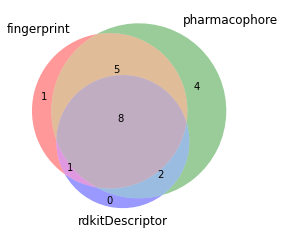

/Users/gvin/miniconda3/envs/redial-2020-latest/lib/python3.7/site-packages/matplotlib_venn/_venn3.py:117: UserWarning: Bad circle positioning
  warnings.warn("Bad circle positioning")


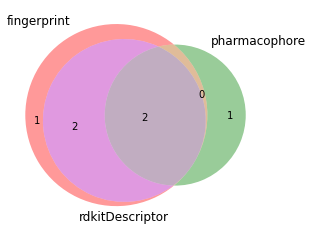

In [17]:
# Venn diagram plot
_files = ['ext_pred_cpe_3cl/cpe_external_set_after_phys-chem-filters_stand.csv', 'ext_pred_cpe_3cl/3cl_external_set_stand.csv']
names = ['CPE', '3CL']
for _f, n in zip(_files, names) :
    plot_venn_diagram(_f, n)

In [18]:
def external_pred_volsurf(ext_files, model):
    files = glob.glob(ext_files)
    for f in files:
        filename = os.path.splitext(os.path.basename(f))[0]
        if model == 'CPE' and filename == 'cpe_external_set_after_phys-chem-filters_stand':
            fingerprint = np.load('external_set_features/'+'lfcfp4-' + filename+'.npy')
            fingerprint_model = \
            pickle.load(open('models_tuned_best/lfcfp4-CPE-balanced_randomsplit7_70_15_15.pkl', 'rb'))
        else:
            continue
        volsurf = np.load('external_set_features/'+ 'volsurf-'+ filename+'.npy')
        volsurf_model = \
        pickle.load(open('models_tuned_best/volsurf-'+ model +'-balanced_randomsplit7_70_15_15.pkl', 'rb'))
        pharma = np.load('external_set_features/'+ 'tpatf-' + filename+'.npy')
        pharma_model = \
        pickle.load(open('models_tuned_best/tpatf-'+ model +'-balanced_randomsplit7_70_15_15.pkl', 'rb'))
        
        fp_list = [fingerprint, volsurf, pharma]
        models_list = [fingerprint_model, volsurf_model, pharma_model]
        
        df_load = pd.read_csv(f)

        fpnames = ['fingerprint', 'volsurf', 'pharmacophore']
        for finger, mod, fpname in zip(fp_list, models_list, fpnames):
            X_true = finger[:,:-1]
            y_true = finger[:,-1]
            y_pred = mod.predict(X_true)
            y_pred_label = y_pred.tolist()
            y_prob = mod.predict_proba(X_true)[:,1]
            df_load.insert(len(df_load.columns), fpname, y_pred_label)
            
            df_load.to_csv('ext_pred_cpe_3cl_volsurf/'+filename+'.csv', index=False)                

In [19]:
external_pred_volsurf('cpe_3cl_ext_set/*.csv', 'CPE')

In [20]:
def plot_venn_diagram(csvFile, n):
    def get_venn_sections(sets):
        num_combinations = 2 ** len(sets)
        bit_flags = [2 ** n for n in range(len(sets))]
        flags_zip_sets = [z for z in zip(bit_flags, sets)]

        combo_sets = []
        for bits in range(num_combinations - 1, 0, -1):
            include_sets = [s for flag, s in flags_zip_sets if bits & flag]
            exclude_sets = [s for flag, s in flags_zip_sets if not bits & flag]
            combo = set.intersection(*include_sets)
            combo = set.difference(combo, *exclude_sets)
            tag = ''.join([str(int((bits & flag) > 0)) for flag in bit_flags])
            combo_sets.append((tag, combo))
        return combo_sets
    df1 = pd.read_csv(csvFile)
    pred_csv1_0_indices = [index for index, element in enumerate(df1['fingerprint'].to_list()) if element == 0]
    pred_csv1_1_indices = [index for index, element in enumerate(df1['fingerprint'].to_list()) if element == 1]

    pred_csv2_0_indices = [index for index, element in enumerate(df1['pharmacophore'].to_list()) if element == 0]
    pred_csv2_1_indices = [index for index, element in enumerate(df1['pharmacophore'].to_list()) if element == 1]

    pred_csv3_0_indices = [index for index, element in enumerate(df1['volsurf'].to_list()) if element == 0]
    pred_csv3_1_indices = [index for index, element in enumerate(df1['volsurf'].to_list()) if element == 1]

    get_common = get_venn_sections([set(pred_csv1_1_indices), set(pred_csv2_1_indices), set(pred_csv3_1_indices)])
    venn3([set(pred_csv1_1_indices), set(pred_csv2_1_indices), set(pred_csv3_1_indices)], set_labels= \
          ['fingerprint', 'pharmacophore', 'volsurf'])
    plt.title(n+' :summary of predicted actives of External Sets')
    plt.savefig('plots/'+n+'-volsurf-ext'+'.png', dpi=600)
    plt.show()

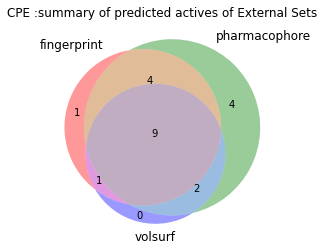

In [21]:
_files = ['ext_pred_cpe_3cl_volsurf/cpe_external_set_after_phys-chem-filters_stand.csv']
names = ['CPE']
for _f, n in zip(_files, names) :
    plot_venn_diagram(_f, n)